# Langkah 3: Interpretasi Persona Cluster

**Tujuan:** Menganalisis *centroid* (pusat) dari setiap cluster untuk memahami karakteristik unik mereka. Kita akan memberi nama pada setiap cluster (misal: "Si Penyelesai Spesialis", "Si Penjelajah Santai", dll.).

**Alur:**
1.  **Muat Data:** Muat `user_features_with_clusters.csv`.
2.  **Hitung Centroids:** Gunakan `groupby('cluster').mean()` untuk menemukan nilai rata-rata dari setiap fitur untuk setiap cluster.
3.  **Visualisasi:** Buat visualisasi (seperti *heatmap* atau *bar plot*) untuk membandingkan cluster secara visual.
4.  **Analisis & Penamaan:** Menganalisis perbedaan dan memberi nama persona.

## 1. Setup & Pemuatan Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mengatur style visualisasi
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
DATA_DIR = '../data/'

try:
    # Muat tabel fitur KITA DENGAN LABEL CLUSTER BARU
    df_clustered = pd.read_csv(os.path.join(DATA_DIR, 'user_features_with_clusters.csv'), index_col='user_id')
    print(f"Clustered feature table loaded successfully. Shape: {df_clustered.shape}")
    print(df_clustered.head())
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Pastikan Anda sudah menjalankan notebook '02_Model_Clustering.ipynb' terlebih dahulu.")

Clustered feature table loaded successfully. Shape: (2692, 16)
         total_explicit_interactions  total_implicit_interactions  \
user_id                                                             
30                                15                          221   
72                                 8                           22   
114                               82                          168   
277                              197                          481   
343                               15                          296   

         avg_watch_pct  completion_rate  drop_off_rate  avg_duration_watched  \
user_id                                                                        
30           21.333333         6.666667      66.666667            204.000000   
72           99.125000       100.000000       0.000000            209.250000   
114          98.426829        98.780488       1.219512            184.780488   
277          88.065990        82.741117       5.58375

## 2. Analisis Centroid (Pusat Cluster)

Ini adalah inti dari interpretasi. Kita akan menghitung nilai rata-rata dari *setiap fitur* untuk *setiap cluster*. 

Contoh: Jika `Cluster 0` memiliki `completion_rate` rata-rata 95% dan `Cluster 1` memiliki 10%, kita tahu `Cluster 0` adalah "Si Penyelesai".

In [3]:
# Hitung centroid untuk setiap cluster
# Ini adalah DataFrame terpenting kita untuk interpretasi
cluster_centroids = df_clustered.groupby('cluster').mean()

print("--- Cluster Centroids (Rata-rata Fitur per Cluster) ---")
print(cluster_centroids)

--- Cluster Centroids (Rata-rata Fitur per Cluster) ---
         total_explicit_interactions  total_implicit_interactions  \
cluster                                                             
0                          21.837284                    49.546875   
1                         214.462264                   482.433962   
2                          14.866348                    50.701671   
3                          13.430868                    32.392283   

         avg_watch_pct  completion_rate  drop_off_rate  avg_duration_watched  \
cluster                                                                        
0            92.990126        88.995548       2.614161            179.808723   
1            92.136260        88.890037       4.316728            248.004638   
2            62.798808        47.575318      22.100663            265.747511   
3            85.354503        78.735600       7.027675            788.930501   

         pref_type_tutorial_pct  pref_type_use_c

## 3. Visualisasi Perbandingan Cluster

Melihat tabel angka bisa jadi sulit. **Heatmap** adalah cara terbaik untuk memvisualisasikan perbedaan ini.

**Tantangan:** Fitur-fitur kita memiliki skala yang sangat berbeda (`total_explicit_interactions` [puluhan] vs `completion_rate` [0-100]). Jika kita mem-plotnya langsung, heatmap-nya akan didominasi oleh fitur bernilai besar.

**Solusi:** Kita akan men-skala-kan *centroid* kita (bukan data asli) menggunakan `MinMaxScaler` sehingga *semua* nilai berada di antara 0 (terendah di cluster itu) dan 1 (tertinggi di cluster itu). Ini membuat perbandingan menjadi adil.

--- Centroids Z-Score (Seberapa jauh dari rata-rata) ---
         total_explicit_interactions  total_implicit_interactions  \
cluster                                                             
0                          -0.517133                    -0.548844   
1                           1.730858                     1.730788   
2                          -0.598486                    -0.542762   
3                          -0.615239                    -0.639182   

         avg_watch_pct  completion_rate  drop_off_rate  avg_duration_watched  \
cluster                                                                        
0             0.791884         0.763381      -0.829386             -0.783208   
1             0.721962         0.757160      -0.608770             -0.503294   
2            -1.680456        -1.678948       1.695646             -0.430467   
3             0.166610         0.158407      -0.257490              1.716968   

         pref_type_tutorial_pct  pref_type_use_

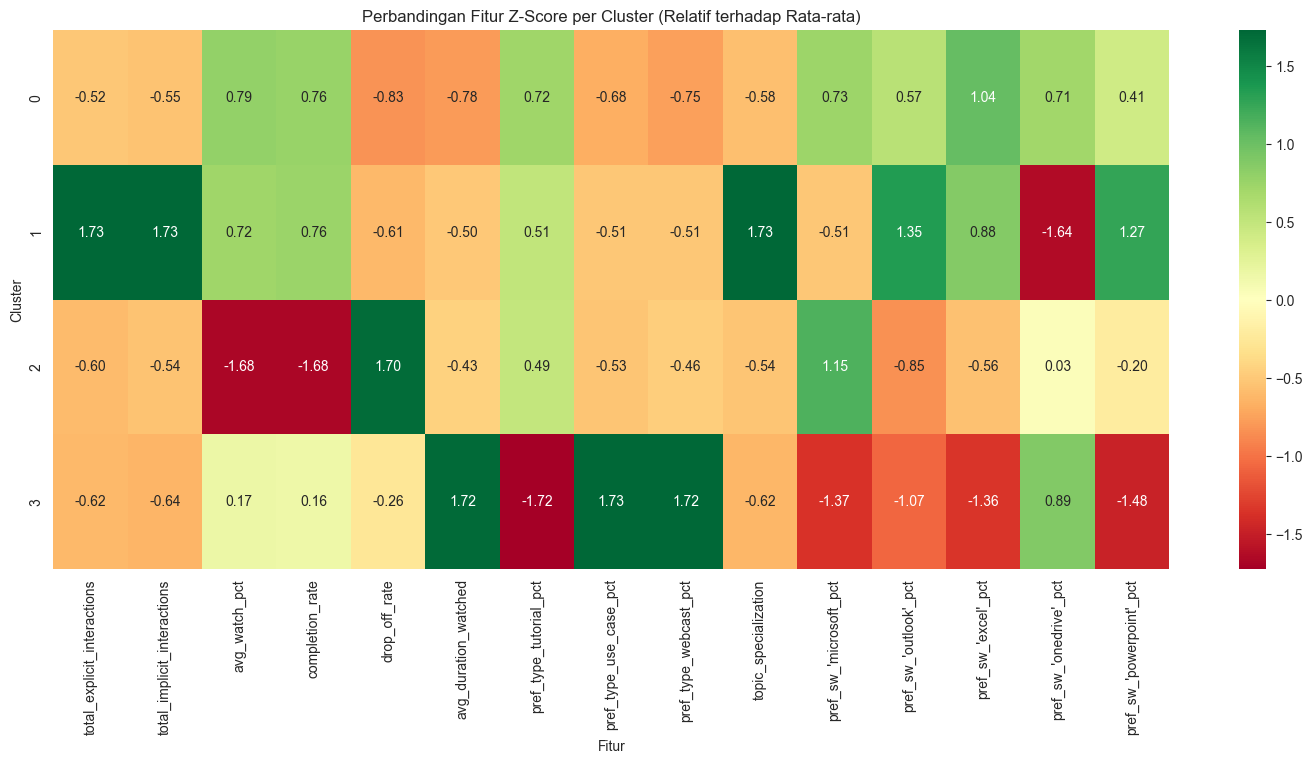

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# --- skala-kan 'cluster_centroids' SECARA LANGSUNG --- 
centroids_zscore = scaler.fit_transform(cluster_centroids)

# Ubah kembali menjadi DataFrame yang rapi
centroids_zscore_df = pd.DataFrame(centroids_zscore, 
                                 columns=cluster_centroids.columns, 
                                 index=cluster_centroids.index)

print("--- Centroids Z-Score (Seberapa jauh dari rata-rata) ---")
print(centroids_zscore_df)

# Buat Heatmap
plt.figure(figsize=(18, 7))
sns.heatmap(centroids_zscore_df, 
            annot=True, 
            fmt='.2f', 
            cmap='RdYlGn', # Merah (Rendah) -> Kuning (Rata-rata) -> Hijau (Tinggi)
            center=0) # Pusatkan palet warna di 0 (rata-rata)

plt.title('Perbandingan Fitur Z-Score per Cluster (Relatif terhadap Rata-rata)')
plt.xlabel('Fitur')
plt.ylabel('Cluster')

plt.show()

## 4. Analisis & Penamaan Persona

Kita telah berhasil. Kita akan menganalisis *output Z-Score* dan *heatmap* di atas untuk memberi nama pada 4 persona kita.

**Metodologi:** Kita akan mencari **fitur pembeda (differentiating features)** — Z-score yang sangat TINGGI (hijau di heatmap, > +1.0) atau sangat RENDAH (merah di heatmap, < -1.0) — untuk setiap cluster.

---

### Persona Cluster 0: "Si Penyelesai Efisien" (Efficient Completer)

Ini adalah siswa 'ideal' kita. Mereka fokus dan menyelesaikan apa yang mereka mulai.

* **`completion_rate` TINGGI:** Z-score **+0.76** (di atas rata-rata).
* **`drop_off_rate` SANGAT RENDAH:** Z-score **-0.82** (paling rendah dari semua cluster).
* **FOKUS PADA TUTORIAL:** `pref_type_tutorial_pct` **+0.72** (sangat suka tutorial).
* **SPESIALISASI RENDAH:** `topic_specialization` **-0.57** (mereka tidak banyak menjelajah).

**Deskripsi:** Siswa ini datang untuk belajar. Mereka sangat menyukai format tutorial singkat, tidak banyak menjelajah topik lain, dan yang terpenting, mereka hampir selalu menyelesaikan apa yang mereka mulai.

### Persona Cluster 1: "Si Penjelajah Ahli" (Power-Explorer)

Ini adalah *power user* kita. Mereka adalah yang paling aktif di seluruh platform.

* **INTERAKSI EKSTREM:** `total_explicit_interactions` (Z-score: **+1.73**) dan `total_implicit_interactions` (Z-score: **+1.73**). Jauh tertinggi.
* **SPESIALISASI EKSTREM:** `topic_specialization` **+1.73** (tertinggi! Mereka mencoba banyak topik).
* **TETAP SERIUS:** `completion_rate` mereka **+0.75** (tetap tinggi, mirip Cluster 0).

**Deskripsi:** Siswa ini "melahap" konten. Mereka menjelajahi banyak topik, menonton video paling banyak, dan mengklik halaman paling banyak. Mereka adalah pengguna yang paling 'engaged' dan paling berharga bagi platform.

### Persona Cluster 2: "Si 'Drop-off'" (The Disengaged)

Ini adalah kelompok 'berisiko' kita, yang perilakunya mirip dengan `user_id 30`.

* **`drop_off_rate` SANGAT TINGGI:** Z-score **+1.69** (paling tinggi dari semua cluster).
* **`completion_rate` SANGAT RENDAH:** Z-score **-1.67** (paling rendah dari semua cluster).
* **`avg_watch_pct` SANGAT RENDAH:** Z-score **-1.68** (paling rendah dari semua cluster).

**Deskripsi:** Siswa di kelompok ini, meskipun sudah melewati filter 5 interaksi, cenderung paling tidak puas. Mereka memulai banyak video tetapi paling sering meninggalkannya. Mereka adalah kelompok 'berisiko' yang mungkin akan meninggalkan platform.

### Persona Cluster 3: "Si Pelajar Mendalam" (The Deep-Diver)

Ini adalah kelompok yang unik dengan preferensi yang sangat spesifik.

* **DURASI SANGAT PANJANG:** `avg_duration_watched` Z-score **+1.71** (tertinggi dari semua cluster).
* **SUKA WEBCAST:** `pref_type_webcast_pct` Z-score **+1.72** (sangat tinggi).
* **TIDAK SUKA TUTORIAL:** `pref_type_tutorial_pct` Z-score **-1.72** (sangat rendah).
* **AKTIVITAS RENDAH:** `total_explicit_interactions` Z-score **-0.61** (terendah).

**Deskripsi:** Siswa ini tidak banyak menonton video. Tapi *ketika* mereka belajar, mereka berkomitmen pada konten yang panjang dan mendalam (webcast). Mereka lebih suka 1 video 30 menit daripada 10 video 3 menit.

## Kesimpulan Langkah 3

Kita telah berhasil menerjemahkan angka abstrak K-Means menjadi 4 *insight* persona yang dapat ditindaklanjuti. Kita sekarang tahu *siapa* pengguna kita.

**Rangkuman Persona:**
1.  **Cluster 0: Si Penyelesai Efisien** (Fokus, suka tutorial, tingkat selesai tinggi)
2.  **Cluster 1: Si Penjelajah Ahli** (Sangat aktif, banyak topik, tetap selesai)
3.  **Cluster 2: Si 'Drop-off'** (Tingkat selesai rendah, berisiko churn)
4.  **Cluster 3: Si Pelajar Mendalam** (Suka konten panjang/webcast)

**Langkah selanjutnya (Langkah 4)** adalah mengambil persona ini dan menyajikannya melalui API menggunakan FastAPI.